In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
import seaborn as sns

In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

X_train = train_data[:, :-1]  
y_train = train_data[:, -1]   

X_test = test_data[:, :-1]   
y_test = test_data[:, -1]     


mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std 


n_components = 110
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca shape: {X_train_pca.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}, y_test shape: {y_test.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train_pca shape: (10000, 110), y_train shape: (10000,)
X_test_pca shape: (5000, 110), y_test shape: (5000,)
X_train shape: (10000, 784), y_train shape: (10000,)
X_test shape: (5000, 784), y_test shape: (5000,)


In [3]:
def ReLU(x):
    return np.maximum(0, x)


In [4]:
def ReLU_derivative(x):
    return (x > 0).astype(float)



In [5]:
def SoftMax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stabilize
    return e_x / np.sum(e_x, axis=1, keepdims=True)



In [6]:
class FFNN_Multiclass:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, a=0.01, epochs=100, batch_size=32, dropout_rate = 0.2, debug=False):
        self.debug = debug
        self.a = a  # learning rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate

        # Initialize weights and biases
        self.wh1 = np.random.normal(0, 0.3, (input_size, hidden_size1))
        self.bh1 = np.random.normal(0, 0.3, (1, hidden_size1))

        self.wh2 = np.random.normal(0, 0.3, (hidden_size1, hidden_size2))
        self.bh2 = np.random.normal(0, 0.3, (1, hidden_size2))

        self.wo = np.random.normal(0, 0.3, (hidden_size2, output_size))
        self.bo = np.random.normal(0, 0.3, (1, output_size))

        self.loss_history = []
        
    
    @staticmethod
    def ReLU(x):
        return np.maximum(0, x)

    @staticmethod
    def ReLU_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def SoftMax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stabilize
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    @staticmethod
    def dropout_forward(inputs, rate, training=True):
        if not training:
            return inputs, None  # No dropout during inference
        mask = np.random.binomial(1, 1 - rate, size=inputs.shape) / (1 - rate)
        return inputs * mask, mask

    @staticmethod
    def dropout_backward(dvalues, mask):
        if mask is None:  # No dropout during inference
            return dvalues
        return dvalues * mask



    def predict_proba(self, X, training=True):
        # Forward pass
        self.zh1 = X @ self.wh1 + self.bh1
        self.ah1 = self.ReLU(self.zh1)

        # Dropout after first hidden layer
        self.ah1_dropout, self.mask1 = self.dropout_forward(self.ah1, rate=self.dropout_rate, training=training)

        self.zh2 = self.ah1_dropout @ self.wh2 + self.bh2
        self.ah2 = self.ReLU(self.zh2)

        # Dropout after second hidden layer
        self.ah2_dropout, self.mask2 = self.dropout_forward(self.ah2, rate=self.dropout_rate, training=training)

        self.zo = self.ah2_dropout @ self.wo + self.bo
        self.ao = self.SoftMax(self.zo)
        return self.ao


    def backpropagate(self, X, y):
        m = X.shape[0]

            # Gradients for output layer
        dL_dzo = self.ao - y
        dzo_dwo = self.ah2_dropout
        dL_dwo = dzo_dwo.T @ dL_dzo / m
        dL_dbo = np.sum(dL_dzo, axis=0, keepdims=True) / m

        # Gradients for second hidden layer
        dzo_dah2 = self.wo
        dL_dah2 = dL_dzo @ dzo_dah2.T
        dah2_dzh2 = self.ReLU_derivative(self.zh2)
        dL_dzh2 = dL_dah2 * dah2_dzh2

        # Apply dropout mask from second hidden layer
        dL_dzh2 = self.dropout_backward(dL_dzh2, self.mask2)

        dzh2_dwh2 = self.ah1_dropout
        dL_dwh2 = dzh2_dwh2.T @ dL_dzh2 / m
        dL_dbh2 = np.sum(dL_dzh2, axis=0, keepdims=True) / m

        # Gradients for first hidden layer
        dzh2_dah1 = self.wh2
        dL_dah1 = dL_dzh2 @ dzh2_dah1.T
        dah1_dzh1 = self.ReLU_derivative(self.zh1)
        dL_dzh1 = dL_dah1 * dah1_dzh1

        # Apply dropout mask from first hidden layer
        dL_dzh1 = self.dropout_backward(dL_dzh1, self.mask1)

        dzh1_dwh1 = X
        dL_dwh1 = dzh1_dwh1.T @ dL_dzh1 / m
        dL_dbh1 = np.sum(dL_dzh1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.wh1 -= self.a * dL_dwh1
        self.bh1 -= self.a * dL_dbh1
        self.wh2 -= self.a * dL_dwh2
        self.bh2 -= self.a * dL_dbh2
        self.wo -= self.a * dL_dwo
        self.bo -= self.a * dL_dbo

    def fit(self, X, y):
        self.loss_history = []
        n_samples = X.shape[0]

        for epoch in range(self.epochs):
            # Shuffle the data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Mini-batch gradient descent
            for i in range(0, n_samples, self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]

                probabilities = self.predict_proba(X_batch)
                self.backpropagate(X_batch, y_batch)

            # Track loss
            probabilities = self.predict_proba(X)
            loss = self.loss(y, probabilities)
            self.loss_history.append(loss)

            if self.debug and epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def loss(self, y, probabilities):
        probabilities = np.clip(probabilities, 1e-9, 1.0)  # Prevent log(0)
        return -np.sum(y * np.log(probabilities)) / y.shape[0]



    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


In [7]:
num_classes = len(np.unique(y_train))  # Determine the number of unique classes
y_train_one_hot = np.eye(num_classes)[y_train.astype(int)]
y_test_one_hot = np.eye(num_classes)[y_test.astype(int)]


In [8]:
model = FFNN_Multiclass(
    input_size=X_train_pca.shape[1],  # Number of features (after PCA)
    hidden_size1=64,                 # Hidden layer 1 neurons
    hidden_size2=32,                 # Hidden layer 2 neurons
    output_size=num_classes,         # Number of classes
    a=0.01,                          # Learning rate
    epochs=200,                      # Training epochs
    batch_size=32,                   # Mini-batch size
    dropout_rate=0.2,                # Specify the dropout rate (e.g., 20%)
    debug=True                       # Debugging info
)


In [9]:
# Train the model
model.fit(X_train_pca, y_train_one_hot)

# Predict and evaluate
#predictions = model.predict(X_test_pca)
#test_accuracy = np.mean(predictions == y_test)
#print(f"Test Accuracy: {test_accuracy:.2%}")


Epoch 0, Loss: 1.0751
Epoch 10, Loss: 0.6508
Epoch 20, Loss: 0.5329
Epoch 30, Loss: 0.4998
Epoch 40, Loss: 0.4740
Epoch 50, Loss: 0.4776
Epoch 60, Loss: 0.4349
Epoch 70, Loss: 0.4303
Epoch 80, Loss: 0.4179
Epoch 90, Loss: 0.3977
Epoch 100, Loss: 0.3917
Epoch 110, Loss: 0.3883
Epoch 120, Loss: 0.3747
Epoch 130, Loss: 0.3771
Epoch 140, Loss: 0.3724
Epoch 150, Loss: 0.3644
Epoch 160, Loss: 0.3651
Epoch 170, Loss: 0.3529
Epoch 180, Loss: 0.3442
Epoch 190, Loss: 0.3352


In [10]:
train_predictions = model.predict(X_train_pca)
train_accuracy = np.mean(train_predictions == y_train)
print(f"Train Accuracy: {train_accuracy:.2%}")

# Evaluate on the test set
test_predictions = model.predict(X_test_pca)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.2%}")


Train Accuracy: 86.36%
Test Accuracy: 81.60%


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(report)



Confusion Matrix:
[[818   1  35  58  88]
 [  3 943   7  35  12]
 [ 12   0 849  21 118]
 [ 37  10  23 888  42]
 [198   2 174  44 582]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.99      0.94      0.96      1000
           2       0.78      0.85      0.81      1000
           3       0.85      0.89      0.87      1000
           4       0.69      0.58      0.63      1000

    accuracy                           0.82      5000
   macro avg       0.81      0.82      0.81      5000
weighted avg       0.81      0.82      0.81      5000



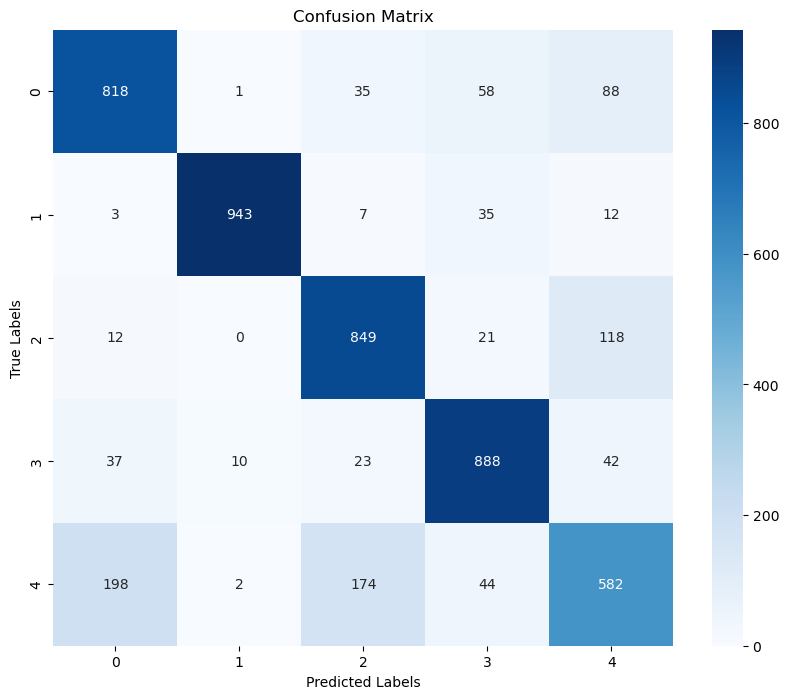

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.99      0.94      0.96      1000
           2       0.78      0.85      0.81      1000
           3       0.85      0.89      0.87      1000
           4       0.69      0.58      0.63      1000

    accuracy                           0.82      5000
   macro avg       0.81      0.82      0.81      5000
weighted avg       0.81      0.82      0.81      5000



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for detailed metrics
report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(report)



In [ ]:
def fit2(self, X, y):
    self.loss_history = []
    self.train_accuracy_history = []  # Track training accuracy
    n_samples = X.shape[0]

    for epoch in range(self.epochs):
        # Shuffle the data
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        # Mini-batch gradient descent
        for i in range(0, n_samples, self.batch_size):
            X_batch = X[i:i + self.batch_size]
            y_batch = y[i:i + self.batch_size]

            probabilities = self.predict_proba(X_batch)
            self.backpropagate(X_batch, y_batch)

        # Track loss and training accuracy
        probabilities = self.predict_proba(X)
        loss = self.loss(y, probabilities)
        self.loss_history.append(loss)

        # Calculate training accuracy
        predictions = np.argmax(probabilities, axis=1)
        y_labels = np.argmax(y, axis=1)
        train_accuracy = np.mean(predictions == y_labels)
        self.train_accuracy_history.append(train_accuracy)

        if self.debug and epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Training Accuracy: {train_accuracy:.4%}")
